In [ ]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("1. Adım Tamam: Kütüphaneler yüklendi.")

1. Adım Tamam: Kütüphaneler yüklendi.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

zip_yolu = '/content/drive/MyDrive/Havacılık Projem/archive.zip'

!unzip -o -q "/content/drive/MyDrive/Havacılık Projem/archive.zip" -d /content/havacilik_verisi

print("Zip başarıyla açıldı!")

Zip başarıyla açıldı!


In [ ]:
xml_yolu = '/content/havacilik_verisi/Annotations/Horizontal Bounding Boxes/*.xml'
annotations = glob.glob(xml_yolu)

data = []
for ann in annotations:
    tree = ET.parse(ann)
    root = tree.getroot()
    filename_from_xml = root.find('filename').text

    base_name = os.path.splitext(filename_from_xml)[0]
    final_filename = base_name + '.jpg'

    label = root.find('.//object/name').text
    data.append((final_filename, label))

df = pd.DataFrame(data, columns=['filename', 'label'])
print("3. Adım Tamam: Uçak isimleri listelendi. İlk 5 uçak:")
print(df.head())

3. Adım Tamam: Uçak isimleri listelendi. İlk 5 uçak:
   filename label
0  3139.jpg    A7
1  3080.jpg   A17
2   571.jpg   A18
3   750.jpg   A10
4   982.jpg    A5


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_dir = '/content/havacilik_verisi/JPEGImages'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=img_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=df,
    directory=img_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 3073 validated image filenames belonging to 20 classes.
Found 768 validated image filenames belonging to 20 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer Learning modeli hazır!")

Transfer Learning modeli hazır!


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=45,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.1167 - loss: 3.2385 - val_accuracy: 0.3555 - val_loss: 2.2102 - learning_rate: 1.0000e-04
Epoch 2/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.3297 - loss: 2.2121 - val_accuracy: 0.4206 - val_loss: 1.8720 - learning_rate: 1.0000e-04
Epoch 3/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.3920 - loss: 2.0305 - val_accuracy: 0.4583 - val_loss: 1.7165 - learning_rate: 1.0000e-04
Epoch 4/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.4295 - loss: 1.8475 - val_accuracy: 0.4987 - val_loss: 1.6133 - learning_rate: 1.0000e-04
Epoch 5/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.4643 - loss: 1.7585 - val_accuracy: 0.5169 - val_loss: 1.5471 - learning_rate: 1.0000e-04
Epoch 6/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5026 - loss: 1.5851 - val_accuracy: 0.5208 - val_loss: 1.5077 - learning_rate: 1.0000e-04
Epoch 7/45
97/97 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5187 

In [ ]:
base_model.trainable = True

fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40, 
    initial_epoch=history.epoch[-1], 
    callbacks=[early_stop, reduce_lr]
)

Epoch 32/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.4267 - loss: 1.8453 - val_accuracy: 0.5885 - val_loss: 1.4962 - learning_rate: 1.0000e-05
Epoch 33/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.4725 - loss: 1.6881 - val_accuracy: 0.5794 - val_loss: 1.5764 - learning_rate: 1.0000e-05
Epoch 34/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.5138 - loss: 1.5735 - val_accuracy: 0.5716 - val_loss: 1.5937 - learning_rate: 1.0000e-05
Epoch 35/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5267 - loss: 1.5480
Epoch 35: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
97/97 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.5267 - loss: 1.5477 - val_accuracy: 0.5560 - val_loss: 1.6139 - learning_rate: 1.0000e-05
Epoch 36/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.5363 - loss: 1.4856 - val_accuracy: 0.5417 - val_loss: 1.5916 - learning_rate: 2.0000e-06
Epoch 37/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.5295

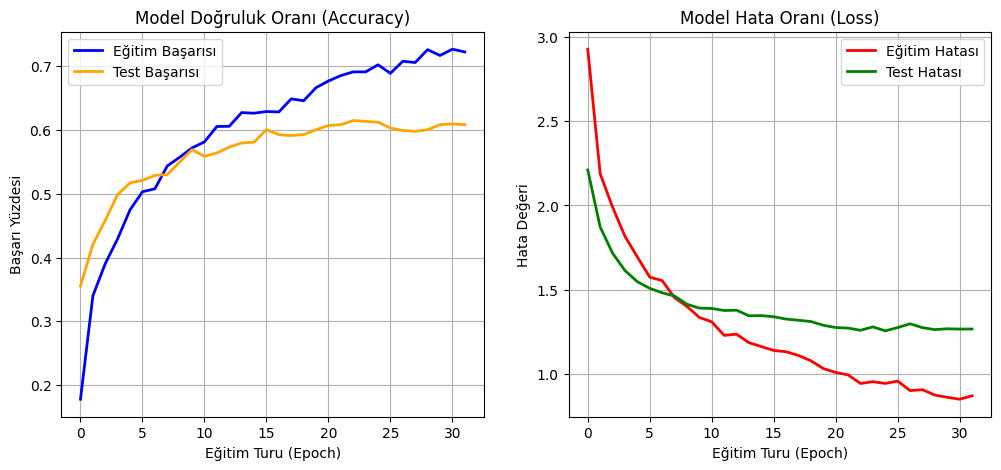

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Başarısı', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Test Başarısı', color='orange', linewidth=2)
plt.title('Model Doğruluk Oranı (Accuracy)')
plt.xlabel('Eğitim Turu (Epoch)')
plt.ylabel('Başarı Yüzdesi')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Hatası', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Test Hatası', color='green', linewidth=2)
plt.title('Model Hata Oranı (Loss)')
plt.xlabel('Eğitim Turu (Epoch)')
plt.ylabel('Hata Değeri')
plt.legend()
plt.grid(True)

plt.show()

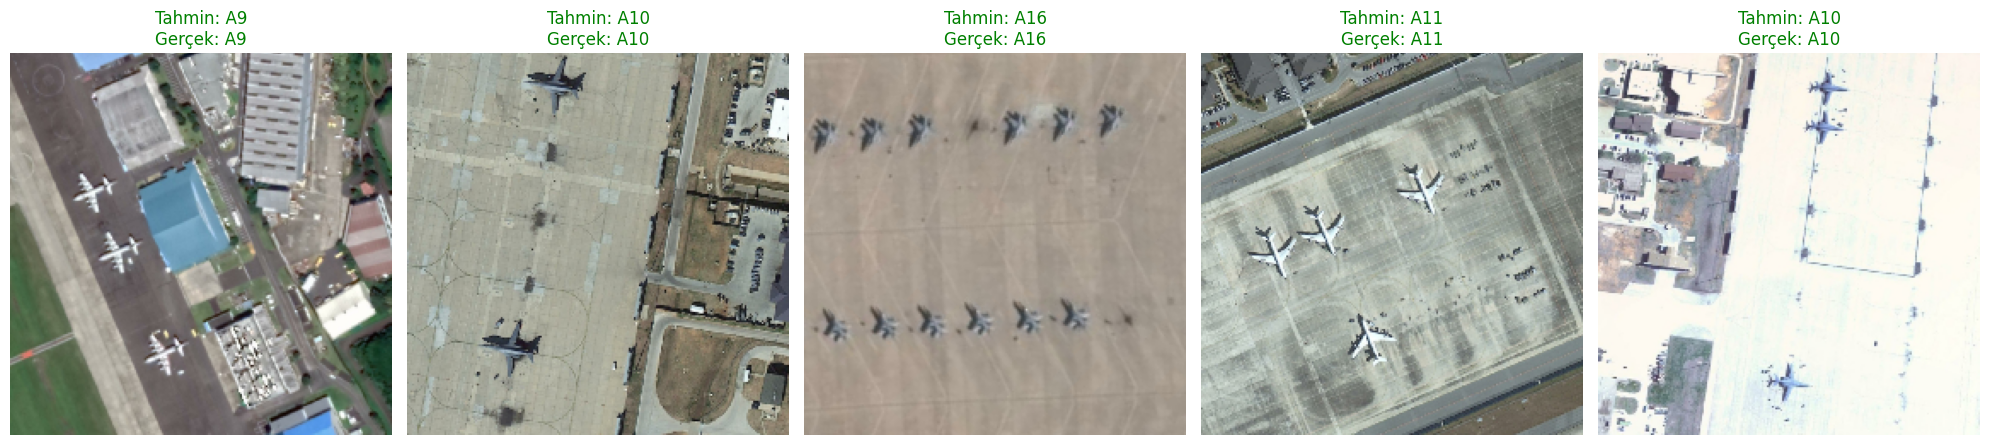

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image
import os 

labels = dict((v,k) for k,v in train_gen.class_indices.items())

rastgele_satirlar = df.sample(5)

plt.figure(figsize=(20, 10))

for i, (index, row) in enumerate(rastgele_satirlar.iterrows()):
    original_filename_from_df = row['filename']

    basename_without_ext = os.path.splitext(original_filename_from_df)[0]
    correct_filename = basename_without_ext + '.jpg'

    img_path = os.path.join(img_dir, correct_filename)

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array, verbose=0)
    tahmin_edilen_isim = labels[np.argmax(prediction)]
    gercek_isim = row['label']

    plt.subplot(1, 5, i+1)
    plt.imshow(img)

    renk = 'green' if tahmin_edilen_isim == gercek_isim else 'red'
    plt.title(f"Tahmin: {tahmin_edilen_isim}\nGerçek: {gercek_isim}", color=renk, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 682ms/step


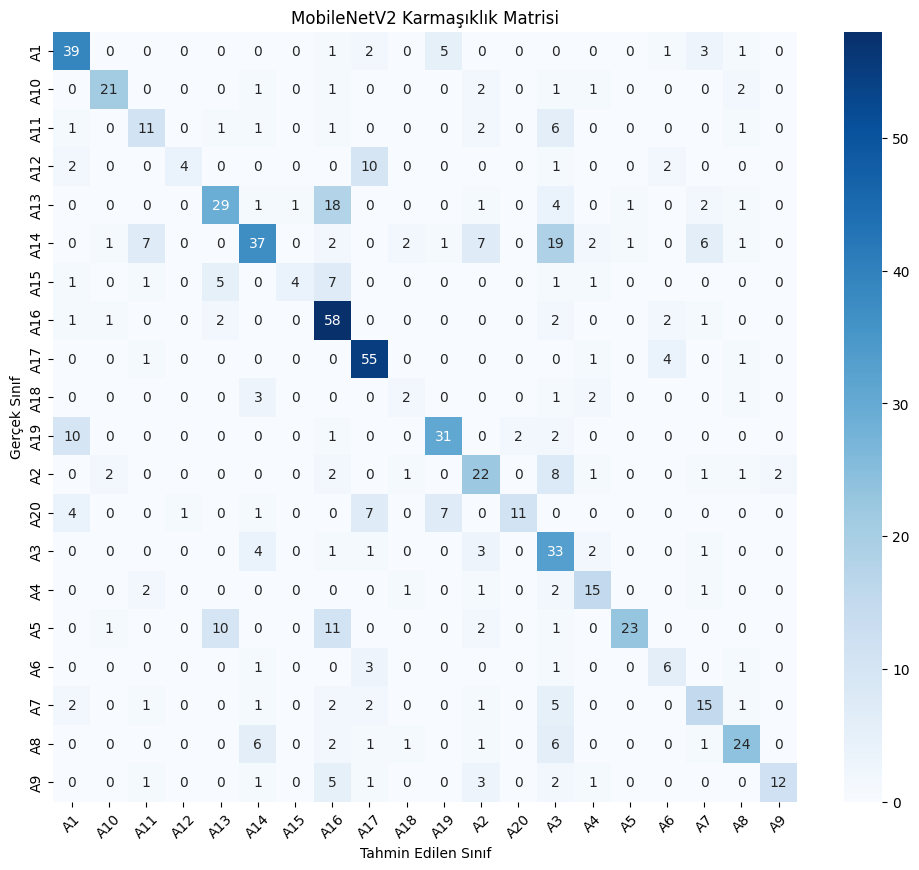


--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

          A1       0.65      0.75      0.70        52
         A10       0.81      0.72      0.76        29
         A11       0.46      0.46      0.46        24
         A12       0.80      0.21      0.33        19
         A13       0.62      0.50      0.55        58
         A14       0.65      0.43      0.52        86
         A15       0.80      0.20      0.32        20
         A16       0.52      0.87      0.65        67
         A17       0.67      0.89      0.76        62
         A18       0.29      0.22      0.25         9
         A19       0.70      0.67      0.69        46
          A2       0.49      0.55      0.52        40
         A20       0.85      0.35      0.50        31
          A3       0.35      0.73      0.47        45
          A4       0.58      0.68      0.62        22
          A5       0.92      0.48      0.63        48
          A6       0.40      0.50      0.44        

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

val_gen.reset() 
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(val_gen.classes, y_pred)
labels = list(val_gen.class_indices.keys())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('MobileNetV2 Karmaşıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.xticks(rotation=45)
plt.show()

print("\n--- Sınıflandırma Raporu ---")
print(classification_report(val_gen.classes, y_pred, target_names=labels))